# Customer Segmentation

### Opportunity

In this project, we explore the dynamic world of online retail by examining a transactional dataset from a UK-based retailer, sourced from the UCI Machine Learning Repository.

The dataset encompasses transactions recorded between 2010 and 2011. Our main goal is to enhance marketing effectiveness and increase sales through customer segmentation. To achieve this, we transform the raw transactional data into a customer-focused format by engineering new features that support the identification of distinct customer segments using the K-means clustering algorithm.

This segmentation enables us to uncover unique customer profiles and gain insights into their behaviors and preferences.



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import iplot

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_excel('online_retail_II.xlsx', sheet_name='Year 2010-2011')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### **Dataset Description:**

**InvoiceNo**:	Code representing each unique transaction. If this code starts with letter 'c', it indicates a cancellation.

**StockCode**:	Code uniquely assigned to each distinct product.

**Description**:	Description of each product.

**Quantity**:	The number of units of a product in a transaction.

**InvoiceDate**:	The date and time of the transaction.

**UnitPrice**:	The unit price of the product in sterling.

**CustomerID**:	Identifier uniquely assigned to each customer.

**Country**:	The country of the customer.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
# Percetage of missing values
missing_percentage = df[['Customer ID', 'Description']].isnull() \
    .mean() * 100
missing_percentage

Customer ID    24.926648
Description     0.268310
dtype: float64

In [8]:
# How much duplicated rows are in the dataset
duplicate_rows = df[df.duplicated(keep=False)]
len(duplicate_rows)

10147

In [9]:
# Drop missing values and duplicated rows
df.dropna(inplace = True)
df.drop_duplicates(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401605 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      401605 non-null  object        
 1   StockCode    401605 non-null  object        
 2   Description  401605 non-null  object        
 3   Quantity     401605 non-null  int64         
 4   InvoiceDate  401605 non-null  datetime64[ns]
 5   Price        401605 non-null  float64       
 6   Customer ID  401605 non-null  float64       
 7   Country      401605 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.6+ MB


In [10]:
# Unique values in each column
{columns: len(df[columns].unique()) for columns in df.columns}

{'Invoice': 22190,
 'StockCode': 3684,
 'Description': 3896,
 'Quantity': 436,
 'InvoiceDate': 20460,
 'Price': 620,
 'Customer ID': 4372,
 'Country': 37}

In [11]:
# Sales of each product
sales_per_product = df.groupby("Description")["Quantity"] \
    .sum() \
    .sort_values(ascending=False)

sales_per_product.head(10)

Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53119
JUMBO BAG RED RETROSPOT               44963
ASSORTED COLOUR BIRD ORNAMENT         35215
WHITE HANGING HEART T-LIGHT HOLDER    34128
PACK OF 72 RETROSPOT CAKE CASES       33386
POPCORN HOLDER                        30492
RABBIT NIGHT LIGHT                    27045
MINI PAINT SET VINTAGE                25880
PACK OF 12 LONDON TISSUES             25305
PACK OF 60 PINK PAISLEY CAKE CASES    24129
Name: Quantity, dtype: int64

In [12]:
# Total price of each transaction
df['TotalPrice'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [13]:
# Countries with the most transactions
df['Country'].value_counts() \
    .head(10)

Country
United Kingdom    356728
Germany             9480
France              8476
EIRE                7475
Spain               2528
Netherlands         2371
Belgium             2069
Switzerland         1877
Portugal            1471
Australia           1258
Name: count, dtype: int64

In [14]:
returned_items = df[df['Invoice'].str.contains('C', na=False)]

df['Transaction_Status'] = np.where(df['Invoice'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop(['Customer ID', 'InvoiceDate'], axis=1)

,Quantity,Price,TotalPrice
count,8872.000000,8872.000000,8872.000000
mean,-30.774910,18.899512,-68.607920
min,-80995.000000,0.010000,-168469.600000
25%,-6.000000,1.450000,-17.000000
50%,-2.000000,2.950000,-8.500000
75%,-1.000000,4.950000,-3.300000
max,-1.000000,38970.000000,-0.120000
std,1172.249902,445.190864,2022.869636


In [15]:
# Cancelled transactions percentage
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100
cancelled_percentage

2.2091358424322407

In [16]:
returned_items['Description'].value_counts() \
    .head(10)

Description
REGENCY CAKESTAND 3 TIER             180
Manual                               175
POSTAGE                               97
JAM MAKING SET WITH JARS              86
Discount                              77
SET OF 3 CAKE TINS PANTRY DESIGN      72
STRAWBERRY CERAMIC TRINKET BOX        54
ROSES REGENCY TEACUP AND SAUCER       53
RECIPE BOX PANTRY YELLOW DESIGN       47
JUMBO BAG RED RETROSPOT               44
Name: count, dtype: int64

In [17]:
# Values of numeric characteres in unique stock codes
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()
numeric_char_counts_in_unique_codes

5    3676
0       7
1       1
Name: count, dtype: int64

In [18]:
# Anomalous stock codes
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

for code in anomalous_stock_codes:
    print(code)

POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [19]:
# Removing rows with anomalous stock codes
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

len(df)

399689

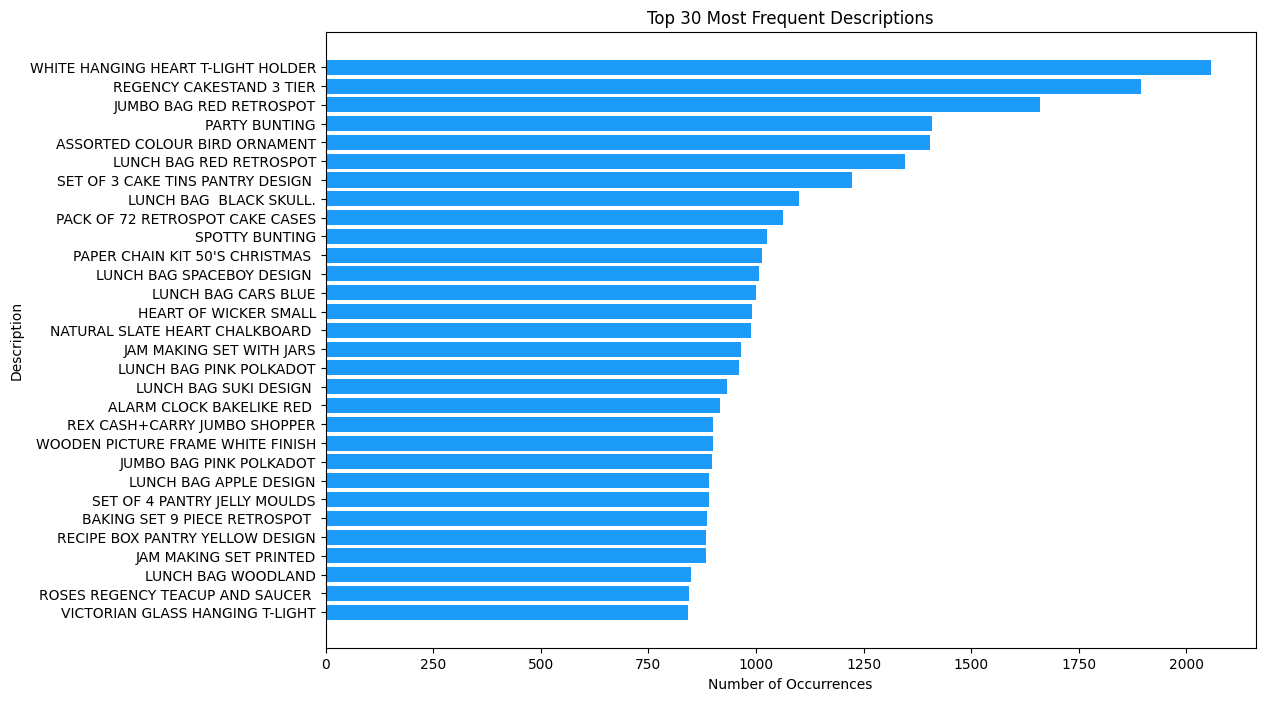

In [20]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#1C9BF9')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [21]:
{columns: len(df[columns].unique()) for columns in df.columns}

{'Invoice': 21788,
 'StockCode': 3676,
 'Description': 3888,
 'Quantity': 432,
 'InvoiceDate': 20135,
 'Price': 373,
 'Customer ID': 4363,
 'Country': 37,
 'TotalPrice': 3756,
 'Transaction_Status': 2}

In [22]:
# First and last date of the dataset
print("Min Date", df["InvoiceDate"].min(), "Max Date", df["InvoiceDate"].max())

Min Date 2010-12-01 08:26:00 Max Date 2011-12-09 12:50:00


In [23]:
# Percentage of transactions by country
df['Country'].value_counts(normalize=True) \
    .head(10)

Country
United Kingdom    0.890968
Germany           0.022720
France            0.020396
EIRE              0.018439
Spain             0.006162
Netherlands       0.005830
Belgium           0.004931
Switzerland       0.004614
Portugal          0.003570
Australia         0.003142
Name: proportion, dtype: float64

## Customer Behavioral Features

In [24]:
# Recency calculation and customer data creation

import datetime as dt
today_date = dt.datetime(2011, 12, 11)

# Calculate the number of days since the last purchase
customer_data = (today_date - df.groupby("Customer ID") \
           .agg({"InvoiceDate":"max"})) \
            .rename(columns = {"InvoiceDate":"Recency"})

customer_data["Recency"] = customer_data["Recency"] \
    .apply(lambda x: x.days)

customer_data.head()

,Recency
Customer ID,
12346.0,326
12347.0,3
12348.0,76
12349.0,19
12350.0,311


In [25]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('Customer ID')['Invoice'] \
                    .nunique() \
                        .reset_index()
total_transactions.rename(columns={'Invoice': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('Customer ID')['Quantity'] \
                            .sum() \
                                .reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='Customer ID')
customer_data = pd.merge(customer_data, total_products_purchased, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased
0,12346.0,326,2,0
1,12347.0,3,7,2458
2,12348.0,76,4,2332
3,12349.0,19,1,630
4,12350.0,311,1,196


In [26]:
# Calculate the total spend by each customer
total_spend = df.groupby('Customer ID')['TotalPrice'] \
            .sum() \
                .reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='Customer ID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['TotalPrice'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='Customer ID')
customer_data = pd.merge(customer_data, average_transaction_value[['Customer ID', 'Average_Transaction_Value']], on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,TotalPrice,Average_Transaction_Value
0,12346.0,326,2,0,0.00,0.000000
1,12347.0,3,7,2458,4310.00,615.714286
2,12348.0,76,4,2332,1437.24,359.310000
3,12349.0,19,1,630,1457.55,1457.550000
4,12350.0,311,1,196,294.40,294.400000


In [27]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('Customer ID')['StockCode'] \
                            .nunique() \
                                .reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,TotalPrice,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,326,2,0,0.00,0.000000,1
1,12347.0,3,7,2458,4310.00,615.714286,103
2,12348.0,76,4,2332,1437.24,359.310000,21
3,12349.0,19,1,630,1457.55,1457.550000,72
4,12350.0,311,1,196,294.40,294.400000,16


In [28]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('Customer ID')['InvoiceDate'] \
                            .apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('Customer ID') \
                                .mean() \
                                    .reset_index()
average_days_between_purchases.rename(columns={'InvoiceDate': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['Customer ID', 'Day_Of_Week']) \
                        .size() \
                            .reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('Customer ID')['Count'].idxmax()][['Customer ID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['Customer ID', 'Hour']) \
                            .size() \
                                .reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('Customer ID')['Count'].idxmax()][['Customer ID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='Customer ID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='Customer ID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,Customer ID,Recency,Total_Transactions,Total_Products_Purchased,TotalPrice,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,326,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,3,7,2458,4310.00,615.714286,103,2.000000,1,14
2,12348.0,76,4,2332,1437.24,359.310000,21,10.846154,3,19
3,12349.0,19,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,311,1,196,294.40,294.400000,16,0.000000,2,16
